In [146]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import exiftool
import json

In [147]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [148]:
def get_bands(image_path):
    # Open the image and read the bands as numpy arrays
    with rasterio.open(image_path) as src:
        blue = src.read(1)
        green = src.read(2)
        red = src.read(3)
    rgb = np.dstack((blue, green, red))
    return blue, green, red, rgb

In [149]:
def get_metadata(image_path):
    # Get the metadata of the image
    with exiftool.ExifTool() as et:
        metadata = json.loads(et.execute(b'-j', image_path))
    return metadata

In [150]:
def get_gsd(metadata, height=0):
    # Extract the GPS Altitude
    altitude = metadata[0].get("EXIF:GPSAltitude")
    print(f"Altitude: {altitude} m")
    focal_length = metadata[0].get("EXIF:FocalLength")  # in mm
    image_width = metadata[0].get("File:ImageWidth")
    # Size of pixel = sensor width (m) / image width (px)
    pixel_pitch = 6.17e-3 / image_width
    gsd = (altitude - height) * pixel_pitch / (focal_length / 1000)
    return gsd


In [151]:
def get_kernel_size(gsd):
    diameter_of_tree = 10  # meters
    # Number of pixels the tree will cover
    area_of_tree = diameter_of_tree / gsd
    # Kernel size for morphological operations
    kernel_size = int(np.sqrt(area_of_tree))
    print(f"Kernel size: {kernel_size}")
    return kernel_size

In [152]:
def get_vari(blue, green, red):
    # Calculate the VARI index
    vari = (green.astype(float) - red.astype(float)) / (
        green.astype(float) + red.astype(float) - blue.astype(float))
    return vari

In [153]:
def threshold(vari, vari_min=0.1, vari_max=0.5):
    # Generate the vegetation mask
    vegetation_mask = np.full(vari.shape, np.nan)
    vegetation_mask[(vari >= vari_min)] = 1

    # Generate the non-vegetation mask
    non_vegetation_mask = np.full(vari.shape, np.nan)
    non_vegetation_mask[vari < vari_min] = 1

    return vegetation_mask, non_vegetation_mask

In [154]:
def smoothing(mask, kernel_size=7):
    # Apply a Gaussian blur to the mask
    blur = cv.GaussianBlur(mask, (kernel_size, kernel_size), 0)
    return blur

In [155]:
def morphological_operations(mask, kernel_size=18):
    # Apply opening and closing morphological operations to the mask

    opening_kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening = cv.morphologyEx(mask, cv.MORPH_OPEN, opening_kernel)

    closing_kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, closing_kernel)

    return closing

In [156]:
def segmentation(mask, rgb):
    # Apply the mask to the RGB image
    mask_overlay = np.zeros_like(rgb)
    mask_overlay[:, :, 0] = 128  # Red channel for purple
    mask_overlay[:, :, 1] = 0  # Green channel for purple
    mask_overlay[:, :, 2] = 128  # Blue channel for purple

    # Apply the filtered mask to the mask overlay
    mask_overlay[mask != 1] = [0, 0, 0]

    # Create the inverse mask
    inverse_mask = np.logical_not(mask).astype(np.uint8)

    # Create an inverse mask overlay with purple color
    inverse_mask_overlay = np.zeros_like(rgb)
    inverse_mask_overlay[:, :, 0] = 128  # Red channel for purple
    inverse_mask_overlay[:, :, 1] = 0  # Green channel for purple
    inverse_mask_overlay[:, :, 2] = 128  # Blue channel for purple

    # Apply the inverse mask to the inverse mask overlay
    inverse_mask_overlay[mask == 1] = [0, 0, 0]

    return mask_overlay, inverse_mask_overlay

In [157]:
def visualize_segmentation(rgb, mask_overlay, inverse_mask_overlay):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    plt.sca(ax[0])
    plt.imshow(rgb)
    plt.axis('off')
    plt.title('RGB')

    plt.sca(ax[1])
    plt.imshow(rgb)
    plt.imshow(mask_overlay, alpha=0.5)
    plt.axis('off')
    plt.title('vegetation segmentation')

    plt.sca(ax[2])
    plt.imshow(rgb)
    plt.imshow(inverse_mask_overlay, alpha=0.5)
    plt.axis('off')
    plt.title('non-veg segmentation')

    plt.show()

In [158]:
def process_image(image_path):
    print(f"Processing image: {image_path}")
    blue, green, red, rgb = get_bands(image_path)
    metadata = get_metadata(image_path)
    gsd = get_gsd(metadata)
    kernel_size = get_kernel_size(gsd)
    vari = get_vari(blue, green, red)
    vegetation_mask, non_vegetation_mask = threshold(vari)
    smoothed_mask = smoothing(vegetation_mask, int(kernel_size / 2))
    filtered_mask = morphological_operations(smoothed_mask, kernel_size)
    mask_overlay, inverse_mask_overlay = segmentation(filtered_mask, rgb)
    return mask_overlay, inverse_mask_overlay


Processing image: data/batch_001/8928dec4ddbffff/DJI_0876.JPG


/Users/kevinlacaille/.pyenv/versions/3.11.4/envs/scipy2024-env/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Altitude: 125.09 m
Kernel size: 18


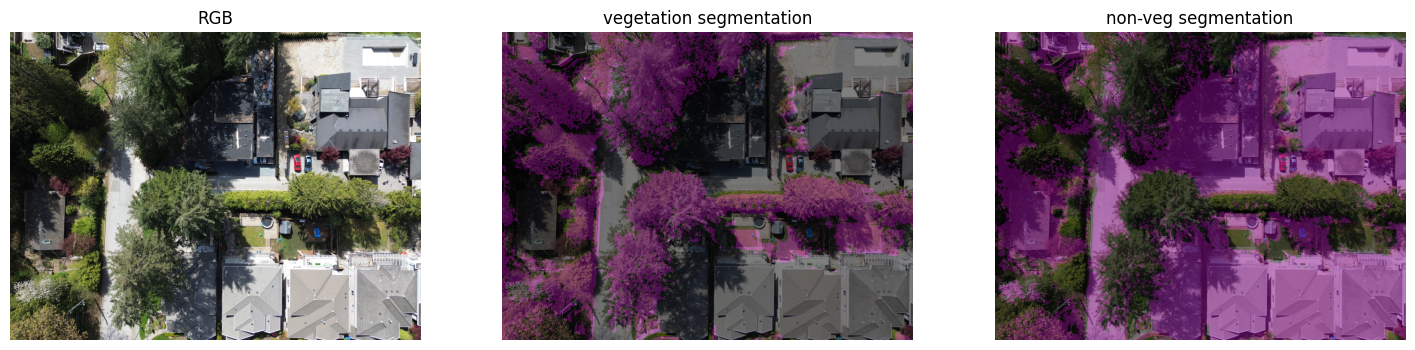

In [160]:
image_path = 'data/batch_001/8928dec4ddbffff/DJI_0876.JPG'
mask_overlay, inverse_mask_overlay = process_image(image_path)
visualize_segmentation(rgb, mask_overlay, inverse_mask_overlay)